In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG, format='{asctime} - {name} - {levelname} - {message}', style='{')
import numpy as np, matplotlib.pyplot as plt, pandas as pd
# For finding and loading multiple files
import os
# Use this to see how much memory the dataframes use
from sys import getsizeof
from pathlib import Path
from linetimer import CodeTimer, linetimer
import yaml
import wrapt

import pseudopeople as psp

from vivarium_research_prl.utils import sizemb, MappingViaAttributes
from vivarium_research_prl import alpha, datatypes, utils

!date
!whoami
!uname -a
!pwd
!python --version
!conda info --envs | grep '\*'
!conda list | grep -e pandas -e numpy -e vivarium -e pseudopeople
!pip freeze | grep pseudopeople

2024-02-03 00:44:05,409 - matplotlib - DEBUG - matplotlib data path: /ihme/homes/ndbs/miniconda3/envs/ppplv1.0-311/lib/python3.11/site-packages/matplotlib/mpl-data
2024-02-03 00:44:05,433 - matplotlib - DEBUG - CONFIGDIR=/ihme/homes/ndbs/.config/matplotlib
2024-02-03 00:44:05,435 - matplotlib - DEBUG - interactive is False
2024-02-03 00:44:05,436 - matplotlib - DEBUG - platform is linux
2024-02-03 00:44:05,614 - matplotlib - DEBUG - CACHEDIR=/ihme/homes/ndbs/.cache/matplotlib
2024-02-03 00:44:05,620 - matplotlib.font_manager - DEBUG - Using fontManager instance from /ihme/homes/ndbs/.cache/matplotlib/fontlist-v330.json
2024-02-03 00:44:06,925 - numexpr.utils - INFO - Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


Sat 03 Feb 2024 12:44:15 AM PST
ndbs
Linux int-slurm-sarchive-p0005 5.4.0-167-generic #184-Ubuntu SMP Tue Oct 31 09:21:49 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
/mnt/share/code/ndbs/vivarium_research_prl/pseudopeople_testing
Python 3.11.7
ppplv1.0-311          *  /ihme/homes/ndbs/miniconda3/envs/ppplv1.0-311
numpy                     1.26.3                   pypi_0    pypi
pandas                    2.1.4                    pypi_0    pypi
pseudopeople              0.8.4.dev32+g8c8f99b          pypi_0    pypi
vivarium                  2.3.1                    pypi_0    pypi
vivarium-research-prl     0.0.1                     dev_0    <develop>
pseudopeople @ git+https://github.com/ihmeuw/pseudopeople.git@8c8f99b4ed3111e3bb0b9cd812c923049e39f7a8


In [3]:
# A clickable link to the GitHub UI to see what version I'm using
! pip freeze | grep pseudopeople | sed -e 's|pseudopeople @ ||' | sed -e 's|git+||' | sed -e 's|\.git@|/tree/|'

https://github.com/ihmeuw/pseudopeople/tree/8c8f99b4ed3111e3bb0b9cd812c923049e39f7a8


# Find data

Project directory:

```
/mnt/team/simulation_science/pub/models/vivarium_census_prl_synth_pop
```

Directory [Zeb sent in Slack](https://ihme.slack.com/archives/C02KUQ9LX32/p1705720235528949?thread_ts=1705713714.552259&cid=C02KUQ9LX32), saying that this is the latest zipped RI data (this is similar to the `latest` run, but the postprocessing date is different):
```
/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/release_02_yellow/full_data/united_states_of_america/2023_08_21_16_35_27/final_results/2023_08_31_15_58_01/
```

In [12]:
project_path = Path('/mnt/team/simulation_science/pub/models/vivarium_census_prl_synth_pop')
usa_path = project_path / 'results/release_02_yellow/full_data/united_states_of_america'

# Not sure what these runs are for...
latest_run = usa_path / 'latest'
best_run = usa_path / 'best'
latest_run_path = usa_path / '2023_08_21_16_35_27/final_results/2024_01_11_07_27_51/pseudopeople_input_data_usa_2.0.0'
best_run_path = usa_path / '2023_07_28_08_33_09/final_results/2023_07_31_08_59_48/'

# I think this is the run we should be using...
last_zipped_sim_path = usa_path / '2023_08_21_16_35_27'
last_zipped_path = last_zipped_sim_path / 'final_results/2023_08_31_15_58_01'

ri_data_dir = last_zipped_path / 'states/pseudopeople_simulated_population_rhode_island_2_0_0'
usa_data_dir = last_zipped_path / 'pseudopeople_simulated_population_usa_2_0_0'


In [17]:
!ls $last_zipped_sim_path

branches.yaml  logs			 __pycache__	   settings.py
final_results  model_specification.yaml  raw_results
keyspace.yaml  output.hdf		 requirements.txt


# Things I want to do

1. Update dtype conversion code in `datatypes.py` to not modify dataframe in place (try creating a list of `Series` and using `pd.concat`)
2. Test the above dtype conversion on the RI data, to be sure I can use it on the USA data
3. Add functions to `utils.py`:

    1. Function to read seeds from `keyspace.yaml`
    2. Function to create a file logger. See [this post](https://stackoverflow.com/questions/10973362/python-logging-function-name-file-name-line-number-using-a-single-file) and [this reference](https://docs.python.org/2/library/logging.html#logrecord-attributes) for how to add function name and line number to the logged messages.
    3. (Two?) decorators to monkey-patch the pseudopeople `generate_x` functions to be able to generate a dataset from a subset of shards. Namely:

        1. Write a decorator to apply to `get_dataset_filepaths` (or possibly `fetch_filepaths`) that filters the contents of the returned list of paths.
        2. Write a decorator to apply to any of the `generate_x` functions that monkey-patches the `pseudopeople` package by replacing `get_dataset_filepaths` with its decorated version, then calling `generate_x`, then replacing `get_dataset_filepaths` with its original value using a `try/finally` block.
        3. Both decorators should accept a list of filters (e.g., seed numbers) to apply to the filepaths.
      
    4. Anything else?
 
5. Continue to add features to the `generate_datasets` function:

    1. Add an `include` parameter in addition to the `skip` parameter (maybe rename `exclude`?)
    2. Add code to automatically apply the above `pseudopeople` monkey-patch to generate datasets from a subset of shards
    3. Add the ability to completely turn off logging by passing `logger=None`. See [this post](https://stackoverflow.com/questions/13521981/implementing-an-optional-logger-in-code) for some options, and also [this reference](https://docs.python.org/3/howto/logging.html#configuring-logging-for-a-library)
  
6. Load one shard of census and one shard of SSA, and compare memory usage, so I can estimate how much memory to request on the cluster
7. Or just launch a cluster job with, e.g., 200 GiB of memory, and generate all RI data, including SSA

# Test getting a new logger

Looks like any new logger inherits the logging level of the root.

## Here are 3 solutions for "turning off" a logger

Quoted from https://github.com/python/cpython/issues/80499, which was cited here: https://stackoverflow.com/questions/2266646/how-to-disable-logging-on-the-standard-error-stream

> In the logging Python library, one can completely disable logging (for all levels) for a particular logger either by setting its `disabled` attribute to `True`, or by adding to it a `lambda record: False` filter, or by adding to it a `logging.NullHandler()` handler (to avoid the `logging.lastResort` handler) and setting its `propagate` attribute to `False` (to avoid log record propagation to its parent loggers):
>
> ```python
> import logging
>
> # 1st solution
> logging.getLogger("foo").disabled = True
>
> # 2nd solution
> logging.getLogger("foo").addFilter(lambda record: False)
>
> # 3rd solution
> logging.getLogger("foo").addHandler(logging.NullHandler())
> logging.getLogger("foo").propagate = False
> ```

However, the first solution is not recommended because the `disabled` attribute is supposed to be private and is intended for other purposes.

In [18]:
dummy_logger = logging.getLogger('dummy')
dummy_logger

<Logger dummy (DEBUG)>

In [19]:
dummy_logger.info('test message')

2024-02-03 01:23:04,287 - dummy - INFO - test message


In [20]:
dummy_logger.parent

<RootLogger root (DEBUG)>

In [21]:
logging.getLogger('root')

<RootLogger root (DEBUG)>

In [22]:
# This apparently doesn't turn off logging...
# But actually, I think it's only because the dummy logger is still propagating to 'root'
dummy_logger.addHandler(logging.NullHandler())
dummy_logger

<Logger dummy (DEBUG)>

In [23]:
dummy_logger.info("another test")

2024-02-03 01:27:25,638 - dummy - INFO - another test


In [24]:
dummy_logger.propagate

True

In [25]:
# Apparently `disabled` is a private attribute and shouldn't be used:
# https://github.com/python/cpython/issues/80499
dummy_logger.disabled

False

In [31]:
dummy_logger.disabled = True
dummy_logger.info("yet another test")

In [32]:
dummy_logger.debug('really?')

In [33]:
dummy_logger.disabled = False
dummy_logger.info("what about now?")

2024-02-03 01:32:16,976 - dummy - INFO - what about now?


In [34]:
# Aha! Turning off propagation silences the logger.
# In order for this to work, it was necessary to add the NullHandler
# to avoid passing the messate to the LastResort logger:
# https://github.com/python/cpython/issues/80499
dummy_logger.propagate = False
dummy_logger.info("And now?")

# Here's another solution for what I actually want to do

From here: https://stackoverflow.com/questions/13521981/implementing-an-optional-logger-in-code

```python
class DummyObject(object):
    def __getattr__(self, name):
        return lambda *args, **kwargs: None

def foo(arg1, arg2, arg3, logger=None):
    logger = logger or DummyObject()
    ...
    logger.debug("The connection is lost.")
```

This seems like a safer option, as it won't incur potential side-affects by modifying a logger that might get used elsewhere.

## Let's test it -- woo hoo!

In [36]:
class DummyObject(object):
    def __getattr__(self, name):
        return lambda *args, **kwargs: None

def foo(arg1, arg2, arg3, logger=None):
    logger = logger or DummyObject()
    ...
    logger.debug("The connection is lost.")

In [37]:
foo(1,2,3)

In [38]:
foo(1,2,3, logging.getLogger())

2024-02-03 02:09:59,820 - root - DEBUG - The connection is lost.


In [39]:
dummy_obj = DummyObject()
dummy_obj.info('yak')

In [40]:
dummy_obj.info

<function __main__.DummyObject.__getattr__.<locals>.<lambda>(*args, **kwargs)>

In [41]:
dummy_obj.debug

<function __main__.DummyObject.__getattr__.<locals>.<lambda>(*args, **kwargs)>

# Generate data for testing

In [35]:
data = alpha.generate_datasets()
data.keylist()

2024-02-03 02:03:55,512 - vivarium_research_prl.alpha - INFO - Function 'generate_datasets' called with args=(), kwargs={}
2024-02-03 02:03:55,516 - vivarium_research_prl.alpha - DEBUG - skip_pattern=re.compile('(?!)')
2024-02-03 02:03:55,517 - vivarium_research_prl.alpha - INFO - Calling function generate_american_community_survey
2024-02-03 02:03:55,957 - vivarium_research_prl.alpha - INFO - Code block 'generate_american_community_survey' took: 0.00731 m
2024-02-03 02:03:55,959 - vivarium_research_prl.alpha - INFO - <class 'pandas.core.frame.DataFrame'> american_community_survey occupies 0.067614 MB in memory
2024-02-03 02:03:55,961 - vivarium_research_prl.alpha - INFO - Calling function generate_current_population_survey
2024-02-03 02:03:56,314 - vivarium_research_prl.alpha - INFO - Code block 'generate_current_population_survey' took: 0.00587 m
2024-02-03 02:03:56,315 - vivarium_research_prl.alpha - INFO - <class 'pandas.core.frame.DataFrame'> current_population_survey occupies 0.0

['american_community_survey',
 'current_population_survey',
 'decennial_census',
 'social_security',
 'taxes_1040',
 'taxes_w2_and_1099',
 'women_infants_and_children']

In [43]:
for x, y, in data.american_community_survey.items():
    print(x, type(y))

simulant_id <class 'pandas.core.series.Series'>
household_id <class 'pandas.core.series.Series'>
survey_date <class 'pandas.core.series.Series'>
first_name <class 'pandas.core.series.Series'>
middle_initial <class 'pandas.core.series.Series'>
last_name <class 'pandas.core.series.Series'>
age <class 'pandas.core.series.Series'>
date_of_birth <class 'pandas.core.series.Series'>
street_number <class 'pandas.core.series.Series'>
street_name <class 'pandas.core.series.Series'>
unit_number <class 'pandas.core.series.Series'>
city <class 'pandas.core.series.Series'>
state <class 'pandas.core.series.Series'>
zipcode <class 'pandas.core.series.Series'>
housing_type <class 'pandas.core.series.Series'>
relationship_to_reference_person <class 'pandas.core.series.Series'>
sex <class 'pandas.core.series.Series'>
race_ethnicity <class 'pandas.core.series.Series'>


In [45]:
for y in data.american_community_survey.keys():
    print(type(y))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


# "Compress" the data

In [49]:
%%time
cdata = MappingViaAttributes({k: datatypes.to_int_and_categorical(df) for k, df in data.items()})
cdata.keylist()

CPU times: user 228 ms, sys: 3.32 ms, total: 231 ms
Wall time: 229 ms


['american_community_survey',
 'current_population_survey',
 'decennial_census',
 'social_security',
 'taxes_1040',
 'taxes_w2_and_1099',
 'women_infants_and_children']

In [50]:
data.taxes_w2_and_1099.memory_usage(deep=True)

Index                               132
simulant_id                      628332
household_id                     619450
employer_id                      356508
ssn                              669669
wages                            609043
employer_name                    777635
employer_street_number           584572
employer_street_name             678046
employer_unit_number             332321
employer_city                    630943
employer_state                    15016
employer_zipcode                 611139
first_name                       620135
middle_initial                   571931
last_name                        626905
mailing_address_street_number    579473
mailing_address_street_name      671943
mailing_address_unit_number      332544
mailing_address_po_box           326027
mailing_address_city             630495
mailing_address_state             15016
mailing_address_zipcode          610779
tax_form                          10131
tax_year                         356508


In [51]:
cdata.taxes_w2_and_1099.memory_usage(deep=True)

Index                               132
simulant_id                       79224
household_id                      79224
employer_id                       14911
ssn                              769567
wages                            848751
employer_name                     45202
employer_street_number            34053
employer_street_name              47496
employer_unit_number              10780
employer_city                     15473
employer_state                    15016
employer_zipcode                  16536
first_name                       188318
middle_initial                    12542
last_name                        368078
mailing_address_street_number    245391
mailing_address_street_name      410726
mailing_address_unit_number       41408
mailing_address_po_box            32700
mailing_address_city              13920
mailing_address_state             15016
mailing_address_zipcode           16411
tax_form                          10131
tax_year                          10019


In [52]:
print(sizemb(data.taxes_w2_and_1099))
print(sizemb(cdata.taxes_w2_and_1099))

11.864725
3.341057


In [53]:
cdata.taxes_w2_and_1099.wages

0       10192
1       28355
2       18243
3        7704
4        3490
        ...  
9898     9585
9899    57906
9900    19609
9901     8061
9902     4961
Name: wages, Length: 9903, dtype: category
Categories (9137, object): ['01051', '1000', '10001', '10007', ..., 'G8962', 'S0098', '|0809', '|5176']

In [54]:
data.taxes_w2_and_1099.wages

0       10192
1       28355
2       18243
3        7704
4        3490
        ...  
9898     9585
9899    57906
9900    19609
9901     8061
9902     4961
Name: wages, Length: 9903, dtype: object

In [55]:
sizemb(data.taxes_w2_and_1099.wages)

0.609207

In [56]:
sizemb(cdata.taxes_w2_and_1099.wages)

0.848915

In [57]:
data.taxes_w2_and_1099.memory_usage(deep=True) - cdata.taxes_w2_and_1099.memory_usage(deep=True)

Index                                 0
simulant_id                      549108
household_id                     540226
employer_id                      341597
ssn                              -99898
wages                           -239708
employer_name                    732433
employer_street_number           550519
employer_street_name             630550
employer_unit_number             321541
employer_city                    615470
employer_state                        0
employer_zipcode                 594603
first_name                       431817
middle_initial                   559389
last_name                        258827
mailing_address_street_number    334082
mailing_address_street_name      261217
mailing_address_unit_number      291136
mailing_address_po_box           293327
mailing_address_city             616575
mailing_address_state                 0
mailing_address_zipcode          594368
tax_form                              0
tax_year                         346489


In [59]:
cdata.taxes_w2_and_1099.employer_street_name

0              ince dr
1          hallmont dr
2                  NaN
3           west id rd
4              buck tl
             ...      
9898        regent ave
9899      barge roa sw
9900         moriah rd
9901      greenwood wy
9902    east jersey st
Name: employer_street_name, Length: 9903, dtype: category
Categories (280, object): ['15th ave southeast', '2nd ave e', '4fh ave w', '4tb ave w', ..., 'yreeflower dr', 'zimer afe', 'zimmer ave', '|sth ave southeast']

In [60]:
cdata.taxes_w2_and_1099.employer_name

0                                  Pikes Creek Campground
1                                       Red's Dairy Queen
2                                             Warrensburg
3                               Nashville City Properties
4                Ecr Whipple Oliver Finley Shoe Sensation
                              ...                        
9898                            Greenway Med Spa Services
9899                          Northwell Health Center Inc
9900                                             Military
9901    Waffle House of Big Daddys Burgers Shakes and ...
9902                                   Vincent's Hospital
Name: employer_name, Length: 9903, dtype: category
Categories (212, object): ['1st Franklin Lakes Nutrition Service', '400', 'A Car Title Loans', 'A Cass Pulaski Area', ..., 'Wireless Verizon Wireless Giants Childcare', 'Woug Jkhnson Park', 'Xjtism and Bob's Big Louie's', 'Yes']

In [61]:
data.decennial_census.memory_usage(deep=True) - cdata.decennial_census.memory_usage(deep=True)

Index                                    0
simulant_id                         567112
household_id                        558708
first_name                          416976
middle_initial                      577639
last_name                           270795
age                                 578651
date_of_birth                      -175922
street_number                       350423
street_name                         270710
unit_number                         301645
city                                635351
state                                    0
zipcode                             613157
housing_type                        663624
relationship_to_reference_person         0
sex                                      0
race_ethnicity                           0
year                                357759
dtype: int64

In [62]:
data.decennial_census.date_of_birth

0        01/14/2001
1        01/30/2000
2        06/04/1960
3        12/05/2005
4        08/05/1989
            ...    
10220    04/24/1950
10221    11/30/1950
10222    05/13/1949
10223    04/13/1967
10224    12/23/1994
Name: date_of_birth, Length: 10225, dtype: object

In [63]:
data.decennial_census

,simulant_id,household_id,first_name,middle_initial,last_name,age,date_of_birth,street_number,street_name,unit_number,city,state,zipcode,housing_type,relationship_to_reference_person,sex,race_ethnicity,year
0,0_123,0_0,Angela,A,Mckinney,19,01/14/2001,1231,riverside dr,NaN,Anytown,WA,00000,Carceral,Institutionalized group quarters population,Female,White,2020
1,0_244,0_0,Marcus,S,Chamberlain,20,01/30/2000,1231,riverside dr,NaN,Anytown,WA,00000,Carceral,Institutionalized group quarters population,Male,White,2020
2,0_691,0_0,Kelvin,M,Higgins,59,06/04/1960,1231,riverside dr,NaN,Anytown,WA,00000,Carceral,Institutionalized group quarters population,Male,Multiracial or Other,2020
3,0_2606,0_0,Michael,M,Scorzelli,14,12/05/2005,1231,riverside dr,NaN,Anytown,WA,NaN,Carceral,Institutionalized group quarters population,Male,Multiracial or Other,2020
4,0_3692,0_0,Dustin,M,Ormiston,30,08/05/1989,NaN,riverside dr,NaN,Anytown,WA,00000,Carceral,Institutionalized group quarters population,Male,Multiracial or Other,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10220,0_2482,0_996,Craig,S,Levi,69,04/24/1950,15200,a forest st,NaN,Anytown,WA,00000,Household,Parent,Male,White,2020
10221,0_2483,0_996,Donna,R,Dont Know,69,11/30/1950,10200,a forest st,NaN,Anytown,WA,00000,Household,Parent,Female,White,2020
10222,0_2487,0_998,Charles,J,Taylor,70,05/13/1949,1121,lida ct,NaN,Anytown,WA,00000,Household,Reference person,Male,White,2020
10223,0_2488,0_998,Rebecca,R,Taylor,52,04/13/1967,1121,lida ct,NaN,Anytown,WA,00000,Household,Opposite-sex spouse,NaN,White,2020


In [70]:
logging.getLogger().setLevel(logging.INFO)

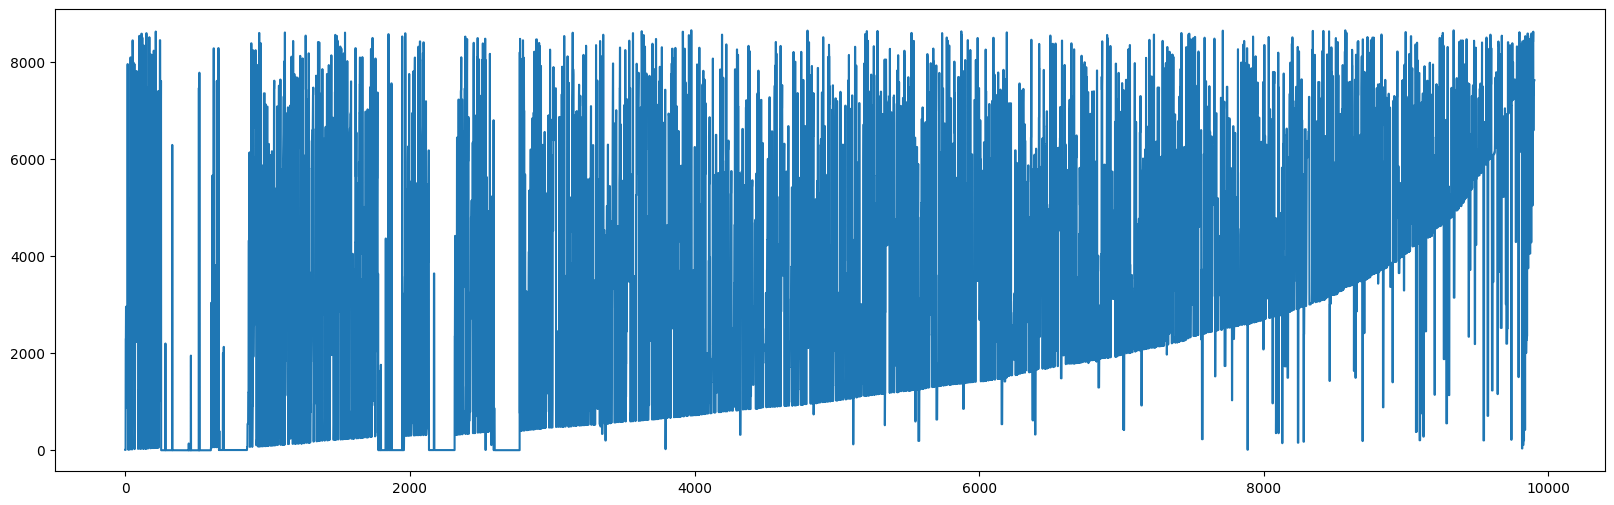

In [72]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(cdata.taxes_w2_and_1099.index, cdata.taxes_w2_and_1099.household_id)

In [73]:
cdata.taxes_w2_and_1099.household_id[:30]

0        8
1        8
2        8
3     2289
4     2289
5     2957
6     2957
7     1070
8     1334
9     1334
10    1334
11    1832
12    1832
13    2183
14     876
15     876
16    7953
17    7953
18     876
19     876
20      14
21      14
22    3397
23    3397
24    3965
25    3965
26    3965
27      16
28      16
29      16
Name: household_id, dtype: int64

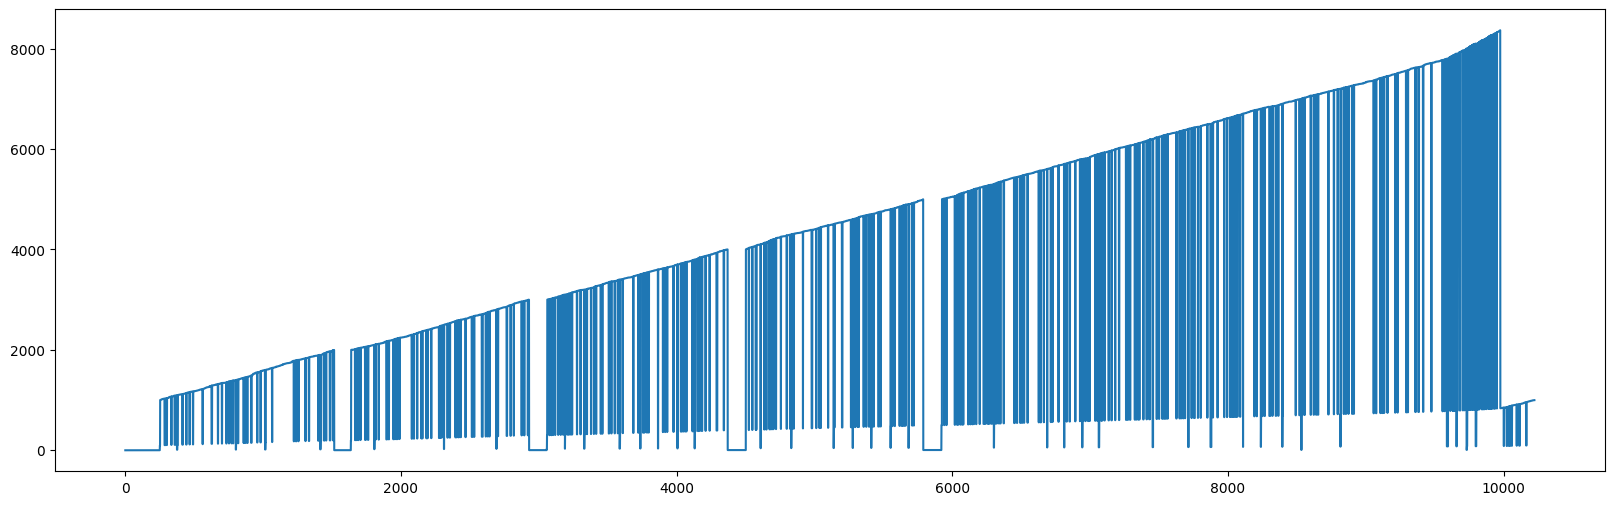

In [74]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(cdata.decennial_census.index, cdata.decennial_census.household_id)

In [79]:
data.decennial_census.household_id[1000:1030]

1000    0_1588
1001    0_1591
1002    0_1591
1003    0_1592
1004    0_1592
1005    0_1593
1006    0_1593
1007    0_1594
1008    0_1595
1009    0_1595
1010    0_1595
1011    0_1598
1012    0_1599
1013    0_1599
1014      0_16
1015      0_16
1016      0_16
1017      0_16
1018     0_160
1019     0_160
1020    0_1603
1021    0_1603
1022    0_1603
1023    0_1604
1024    0_1606
1025    0_1607
1026    0_1607
1027    0_1607
1028    0_1607
1029    0_1607
Name: household_id, dtype: object

In [80]:
data.taxes_1040.memory_usage(deep=True) - cdata.taxes_1040.memory_usage(deep=True)

Index                                 0
simulant_id                      361558
household_id                     355774
first_name                       218102
middle_initial                   367108
last_name                        138172
ssn                             -271456
mailing_address_street_number    155223
mailing_address_street_name       62259
mailing_address_unit_number      190074
mailing_address_po_box           189350
mailing_address_city             404881
mailing_address_state                 0
mailing_address_zipcode          389862
spouse_first_name                184578
spouse_middle_initial            216294
spouse_last_name                 163168
spouse_ssn                       159084
dependent_1_first_name           176183
dependent_1_last_name            143389
dependent_1_ssn                  132332
dependent_2_first_name           181935
dependent_2_last_name            167135
dependent_2_ssn                  163816
dependent_3_first_name           188372


In [81]:
data.social_security.memory_usage(deep=True) - cdata.social_security.memory_usage(deep=True)

Index                  0
simulant_id       915037
ssn              1055808
first_name        760178
middle_name       760765
last_name         561022
date_of_birth     -46954
sex                    0
event_type             0
event_date        -43900
dtype: int64

In [82]:
data.american_community_survey.memory_usage(deep=True) - cdata.american_community_survey.memory_usage(deep=True)

Index                                  0
simulant_id                         4130
household_id                        3863
survey_date                            0
first_name                         -1740
middle_initial                      2592
last_name                          -1996
age                                 1069
date_of_birth                      -2178
street_number                       4022
street_name                         4667
unit_number                         2154
city                                4426
state                                  0
zipcode                             4222
housing_type                        4240
relationship_to_reference_person       0
sex                                    0
race_ethnicity                         0
dtype: int64

In [83]:
data.current_population_survey.memory_usage(deep=True) - cdata.current_population_survey.memory_usage(deep=True)

Index                0
simulant_id       2218
household_id      2199
survey_date          0
first_name        -861
middle_initial     738
last_name         -215
age               -667
date_of_birth    -1045
street_number     -264
street_name       -233
unit_number       1100
city              2284
state                0
zipcode           2148
sex                  0
race_ethnicity       0
dtype: int64

In [85]:
data.women_infants_and_children.memory_usage(deep=True) - cdata.women_infants_and_children.memory_usage(deep=True)

Index                0
simulant_id       7791
household_id      7681
first_name       -3826
middle_initial    6038
last_name          613
date_of_birth    -3106
street_number      554
street_name        841
unit_number       4137
city              8520
state                0
zipcode           8218
sex                  0
race_ethnicity       0
year              4784
dtype: int64

In [86]:
cdata.social_security.date_of_birth

0        19191204
1        19210616
2        19220113
3        19220305
4        19220306
           ...   
16492    19800224
16493    19860415
16494    19950118
16495    20201230
16496    20201231
Name: date_of_birth, Length: 16497, dtype: category
Categories (12570, object): ['00181204', '09330331', '09440125', '09552431', ..., '|987||29', '|989110G', '|9930405', '|9930526']

In [91]:
cdata.current_population_survey.first_name

0         Delores
1         Cameron
2            Lois
3            Grek
4          Doreen
5          Samuel
6         Carolyn
7             Zoe
8           Steve
9          Randal
10           Teri
11          Scott
12       Kimberly
13    Christopher
14           Anna
15       Victoria
16         Philip
17           Mark
18          Drake
19          Brady
20         Philip
21      Madeleine
22           Paul
23       Jeremiah
24           Paul
25          Scott
26         Pierce
27          Keith
28         Thomas
29         Hannah
30       Victoria
31          Aaron
32       Lawrence
33         Melody
34    Daughter Of
35          Laura
36           Kali
37           Kane
38        Melissa
39        Raymond
Name: first_name, dtype: category
Categories (36, object): ['Aaron', 'Anna', 'Brady', 'Cameron', ..., 'Teri', 'Thomas', 'Victoria', 'Zoe']

In [92]:
cdata.taxes_1040.spouse_ssn

0               NaN
1               NaN
2               NaN
3       037-53-5358
4               NaN
           ...     
6513            NaN
6514            NaN
6515            NaN
6516            NaN
6517            NaN
Name: spouse_ssn, Length: 6518, dtype: category
Categories (622, object): ['004-78-8335', '005-75-2115', '006-77-6962', '007-59-7734', ..., '991-83-5611', '996-82-2449', '999-83-8127', '999-99-9858']

In [93]:
data.taxes_1040.spouse_ssn

0               NaN
1               NaN
2               NaN
3       037-53-5358
4               NaN
           ...     
6513            NaN
6514            NaN
6515            NaN
6516            NaN
6517            NaN
Name: spouse_ssn, Length: 6518, dtype: object

In [94]:
data.taxes_1040.ssn

0       674-27-1745
1       186-59-6048
2       633-24-4997
3       037-53-5358
4       124-24-0024
           ...     
6513    885-57-0306
6514    125-19-8492
6515    051-81-6585
6516    542-61-5912
6517    074-43-7334
Name: ssn, Length: 6518, dtype: object

In [95]:
wages = pd.to_numeric(data.taxes_w2_and_1099.wages, errors='coerce')
wages

0       10192.0
1       28355.0
2       18243.0
3        7704.0
4        3490.0
         ...   
9898     9585.0
9899    57906.0
9900    19609.0
9901     8061.0
9902     4961.0
Name: wages, Length: 9903, dtype: float64

<Axes: >

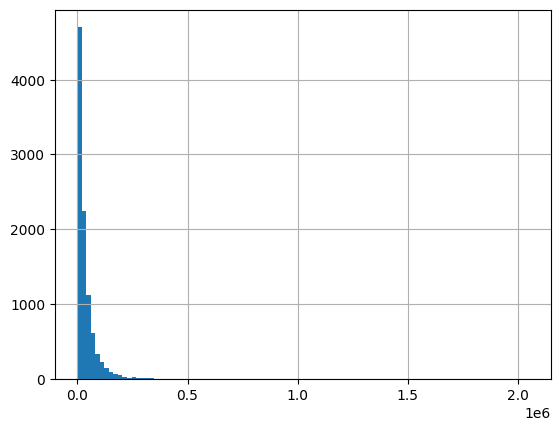

In [96]:
wages.hist(bins=100)

In [97]:
wages.describe()

count    9.777000e+03
mean     3.901173e+04
std      6.293601e+04
min      1.220000e+02
25%      8.683000e+03
50%      2.172800e+04
75%      4.731500e+04
max      2.046557e+06
Name: wages, dtype: float64

<Axes: >

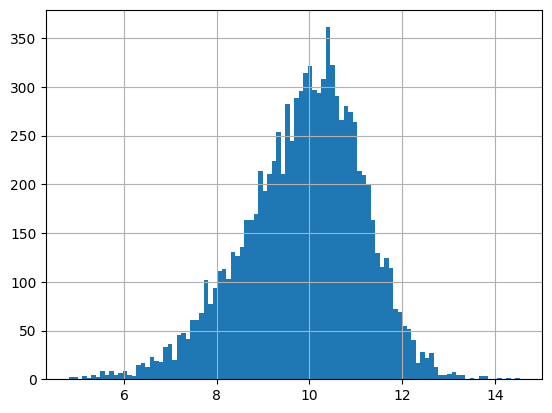

In [98]:
np.log(wages).hist(bins=100)